# 1.Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 2.split the data

In [32]:
df = pd.read_csv("insurance_fixed_clean.csv")

X = df.drop('charges', axis=1)
y = df['charges']

# log transform target (handles skew)
y_log = np.log(y + 1)  # +1 avoids log(0), though min is >0

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"Data split done → Train: {X_train.shape}, Test: {X_test.shape}")
print("Target successfully log-transformed")

Data split done → Train: (1051, 8), Test: (263, 8)
Target successfully log-transformed


# 3.Build and Training Model

In [33]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("\nRandom Forest model trained successfully!")


Random Forest model trained successfully!


# 4. Make Predictions

In [34]:
y_pred_train_log = rf.predict(X_train)
y_pred_test_log = rf.predict(X_test)

# Reverse log transform
y_train_pred = np.expm1(y_pred_train_log)
y_test_pred = np.expm1(y_pred_test_log)
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

# 5.Evaluate the Model

In [35]:
# training metrics (on train split only)
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_r2 = r2_score(y_train_actual, y_train_pred)

test_mae = mean_absolute_error(y_test_actual, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
test_r2 = r2_score(y_test_actual, y_test_pred)

# Practical accuracy (±20% and ±30%)
within_20 = np.mean(np.abs((y_test_actual - y_test_pred) / y_test_actual) <= 0.20) * 100
within_30 = np.mean(np.abs((y_test_actual - y_test_pred) / y_test_actual) <= 0.30) * 100

print("\n" + "="*60)
print("RANDOM FOREST REGRESSOR")
print("="*60)
print(f"Test R² Score      : {test_r2* 100:.1f} ")
print(f"Test MAE           : ${test_mae:,.0f}")
print(f"Test RMSE          : ${test_rmse:,.0f}")
print(f"±20% Accurate      : {within_20:.1f}%")
print(f"±30% Accurate      : {within_30:.1f}%")
print(f"Train R²           : {train_r2* 100:.1f}")
print("="*60)


RANDOM FOREST REGRESSOR
Test R² Score      : 89.1 
Test MAE           : $2,027
Test RMSE          : $4,274
±20% Accurate      : 68.1%
±30% Accurate      : 78.7%
Train R²           : 87.8


# 6.Visualizations

C:\Users\HP\AppData\Local\Temp\ipykernel_4704\1345073096.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_series.values, y=feat_series.index, ax=axes[2], palette='viridis')


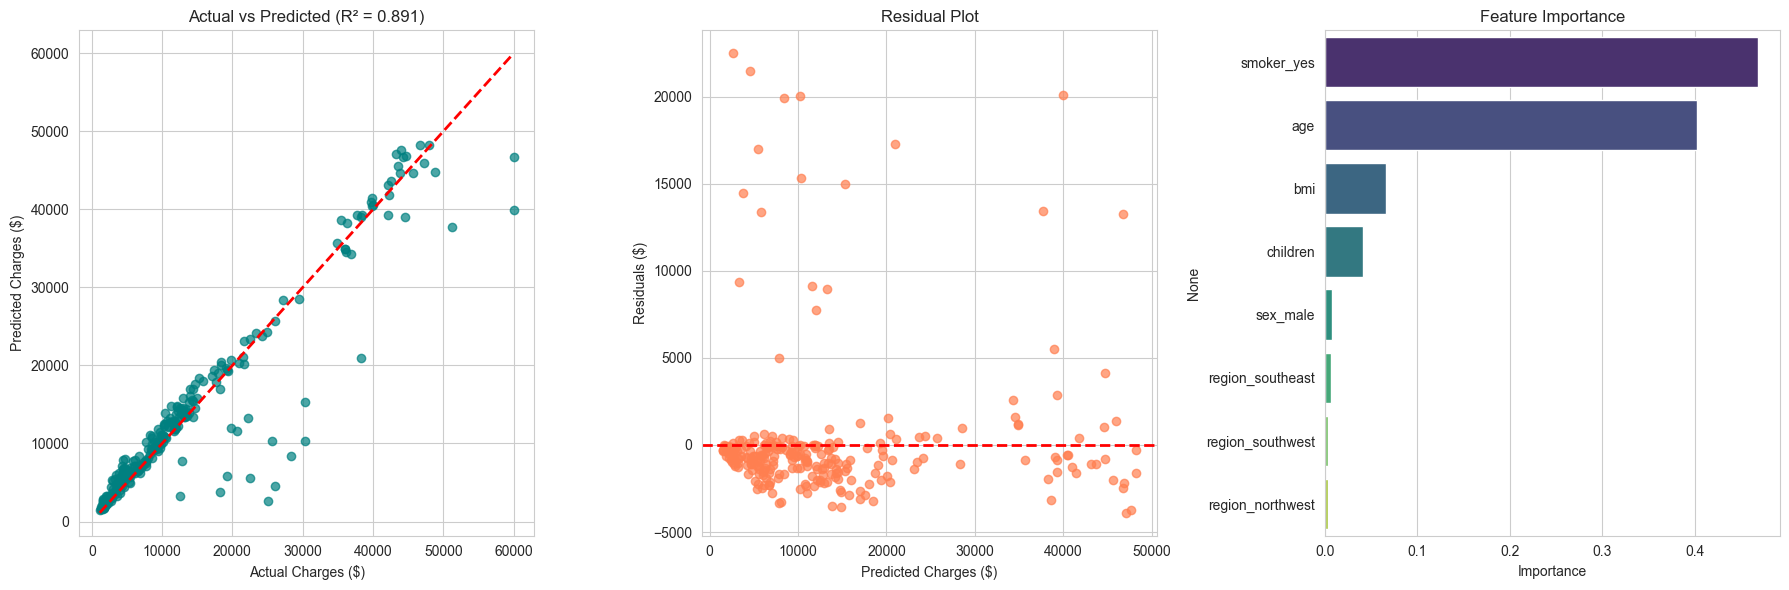

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Actual vs Predicted
axes[0].scatter(y_test_actual, y_test_pred, alpha=0.7, color='teal')
axes[0].plot([y_test_actual.min(), y_test_actual.max()], 
             [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Charges ($)')
axes[0].set_ylabel('Predicted Charges ($)')
axes[0].set_title(f'Actual vs Predicted (R² = {test_r2:.3f})')

# 2. Residual Plot
residuals = y_test_actual - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.7, color='coral')
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Charges ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('Residual Plot')
# 3. Feature Importance
importances = rf.feature_importances_
feat_series = pd.Series(importances, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feat_series.values, y=feat_series.index, ax=axes[2], palette='viridis')
axes[2].set_title('Feature Importance')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# 7.Prediction Results Table

In [37]:
results_df = pd.DataFrame({
    'Actual Charges': y_test_actual.round(2),
    'Predicted Charges': y_test_pred.round(2),
    'Difference': (y_test_actual - y_test_pred).round(2),
    'Absolute Error': np.abs(y_test_actual - y_test_pred).round(2),
    '% Error': (np.abs(y_test_actual - y_test_pred) / y_test_actual * 100).round(1)
}).reset_index(drop=True)

print("\nPrediction Results (First 15 rows):")
print(results_df.head(15))


Prediction Results (First 15 rows):
    Actual Charges  Predicted Charges  Difference  Absolute Error  % Error
0         60000.00           39937.05    20062.95        20062.95     33.4
1         39836.52           40401.76     -565.24          565.24      1.4
2         26018.95            4562.62    21456.33        21456.33     82.5
3         11840.78           11863.78      -23.01           23.01      0.2
4         22478.60           23431.43     -952.83          952.83      4.2
5          6289.75            6624.66     -334.91          334.91      5.3
6          5458.05            6861.04    -1402.99         1402.99     25.7
7         30260.00           15262.93    14997.07        14997.07     49.6
8          7639.42            7106.24      533.18          533.18      7.0
9         18310.74           20070.15    -1759.40         1759.40      9.6
10         1917.32            2154.81     -237.49          237.49     12.4
11        43578.94           45613.47    -2034.53         2034.

# 8. Predict on New Sample

In [38]:
new_sample = pd.DataFrame({
    'age': [35],
    'bmi': [28.5],
    'children': [2],
    'sex_male': [1],
    'smoker_yes': [0],
    'region_northwest': [1],
    'region_southeast': [0],
    'region_southwest': [0]
})

pred_log = rf.predict(new_sample)[0]
predicted_charge = np.expm1(pred_log)

print(f"\nPredicted Insurance Charge for new sample: ${predicted_charge:,.2f}")


Predicted Insurance Charge for new sample: $6,515.26
